Read CSV data with Pandas.

In [1]:
import pandas as pd
import numpy as np

# team stats
team_summaries = pd.read_csv('nba_data/stats_archive/Team Summaries.csv')
# team_totals = pd.read_csv('nba_data/stats_archive/Team Totals.csv')
team_per100 = pd.read_csv('nba_data/stats_archive/Team Stats Per 100 Poss.csv')

# player stats
# player_totals = pd.read_csv('nba_data/stats_archive/Player Totals.csv')
player_shooting = pd.read_csv('nba_data/stats_archive/Player Shooting.csv')
player_play_by_play = pd.read_csv('nba_data/stats_archive/Player Play By Play.csv')
player_per100 = pd.read_csv('nba_data/stats_archive/Per 100 Poss.csv')

# games
games = pd.read_csv('nba_data/game_archive/games.csv')
teamids = pd.read_csv('nba_data/game_archive/teams.csv')


Remove unnecessary features.

In [2]:
# games
teamids['TEAM_NAME'] = teamids['CITY'] + ' ' + teamids['NICKNAME']
teamids = teamids[['TEAM_ID','TEAM_NAME','ABBREVIATION']]

games = games[['GAME_DATE_EST','GAME_ID','HOME_TEAM_ID','VISITOR_TEAM_ID','SEASON','HOME_TEAM_WINS','PTS_home','PTS_away']]

In [3]:
# team stats
team_stats = team_summaries.merge(team_per100)
team_stats.drop(columns=['playoffs','arena','attend','lg'], inplace=True)

# player stats
player_stats = player_shooting.merge(player_play_by_play).merge(player_per100)
player_stats.drop(columns=['birth_year','pos','lg'], inplace=True)

Create player efficiency indices.

𝐼NBA=𝑁pts+𝑁rbs+𝑁asts+𝑁stls+𝑁blcks−(𝑁msFld+𝑁msFT+𝑁tos)

In [4]:
player_stats['player_eff_ind'] = (player_stats['pts_per_100_poss'] +
                           player_stats['trb_per_100_poss'] +
                           player_stats['ast_per_100_poss'] +
                           player_stats['stl_per_100_poss'] +
                           player_stats['blk_per_100_poss'] -
                           (player_stats['tov_per_100_poss'] +
                            player_stats['fga_per_100_poss'] - player_stats['fg_per_100_poss'] +
                            player_stats['fta_per_100_poss'] - player_stats['ft_per_100_poss']))
# player_stats

Create team efficiency indices.

In [5]:
#create the team efficeny index by summing the players by season and team 
team_eff_ind = player_stats.groupby(['tm', 'season'])['player_eff_ind'].sum().reset_index(name='team_eff_ind')
team_eff_ind.rename(columns = {'tm':'abbreviation'}, inplace = True)

In [6]:
#merging the team efficeny index to team_stats
team_stats = team_stats.merge(team_eff_ind)
# team_stats

To each game, append home and away team stats in the respective season.

In [7]:
# add team_id to team stats
teamids.rename(columns = {'ABBREVIATION':'abbreviation','TEAM_NAME':'team'}, inplace = True)
team_stats = team_stats.merge(teamids)
team_stats.drop(columns=['team','abbreviation'], inplace = True)

In [8]:
min(team_stats.season)

1997

In [9]:
# add home team stats to games
h_team_stats = team_stats.add_prefix('h_')
final_df = games.merge(h_team_stats, left_on=['HOME_TEAM_ID','SEASON'], right_on=['h_TEAM_ID','h_season'])
final_df.drop(columns=['h_season','h_TEAM_ID'], inplace = True)

# add away team stats to games
a_team_stats = team_stats.add_prefix('a_')
final_df = final_df.merge(a_team_stats, left_on=['VISITOR_TEAM_ID','SEASON'], right_on=['a_TEAM_ID','a_season'])
final_df.drop(columns=['a_season','a_TEAM_ID'], inplace = True)

In [10]:
# sort games by date, ascending
final_df['GAME_DATE_EST'] = pd.to_datetime(final_df['GAME_DATE_EST'])
final_df = final_df.sort_values(by='GAME_DATE_EST', ascending=True).reset_index(drop=True)

Add novel features from the parent paper.

In [11]:
import warnings
warnings.filterwarnings("ignore")

final_df = final_df[final_df['HOME_TEAM_WINS'].notna()]

def get_avg_win_pct_last_n_games(team, game_date, df, n):
    # Extract the last 10 games 
    prev_game_df = df[df['GAME_DATE_EST'] < game_date][(df['HOME_TEAM_ID'] == team) | (df['VISITOR_TEAM_ID'] == team)].tail(n)
    
    wins = 0 
    # Filter columns to include only 'Home' team and result, then divide into home and away games        
    result_df = prev_game_df
    h_df = result_df.loc[result_df['HOME_TEAM_ID'] == team] 
    
    h_wins = h_df.loc[h_df['HOME_TEAM_WINS'] == 1]
    
    wins += len(h_wins)
    
    a_df = result_df.loc[result_df['HOME_TEAM_ID'] != team]
    a_wins = a_df.loc[a_df['HOME_TEAM_WINS'] == 0]
    
    wins += len(a_wins)

    return wins/n

for index, row in final_df.iterrows() : 
    game_id = row['GAME_ID']
    game_date = row['GAME_DATE_EST']
    h_team = row['HOME_TEAM_ID']
    a_team = row['VISITOR_TEAM_ID']
    final_df.loc[index,'H_w_pct_10'] = get_avg_win_pct_last_n_games(h_team, game_date, final_df, 10)
    final_df.loc[index,'A_w_pct_10'] = get_avg_win_pct_last_n_games(a_team, game_date, final_df, 10)

# final_df.head(20)

In [12]:
# Home and road team win probabilities implied by Elo ratings and home court adjustment 
import math
# import time

final_df = final_df[final_df['PTS_away'].notna() & final_df['PTS_home'].notna()]

# Calculate win probabilities using Elo ratings and home court advantage
def win_probs(home_elo, away_elo, home_court_advantage) :
    h = math.pow(10, home_elo/400)
    r = math.pow(10, away_elo/400)
    a = math.pow(10, home_court_advantage/400) 

    denom = r + a*h
    home_prob = a*h / denom
    away_prob = r / denom 
  
    return home_prob, away_prob

# Calculate odds of the home team winning based on Elo ratings and home court advantage
def home_odds_on(home_elo, away_elo, home_court_advantage) :
    h = math.pow(10, home_elo/400)
    r = math.pow(10, away_elo/400)
    a = math.pow(10, home_court_advantage/400)
    return a*h/r

# Determines the K factor in Elo rating updates, considering the margin of victory and Elo rating difference
def elo_k(MOV, elo_diff):
    k = 20
    if MOV>0:
        multiplier=(MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier=(-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
    return k*multiplier

# Update Elo ratings for both teams following a game, considering the outcome and game specifics
def update_elo(home_score, away_score, home_elo, away_elo, home_court_advantage) :
    home_prob, away_prob = win_probs(home_elo, away_elo, home_court_advantage) 

    if (home_score - away_score > 0) :
        home_win = 1 
        away_win = 0 
    else :
        home_win = 0 
        away_win = 1 
  
    k = elo_k(home_score - away_score, home_elo - away_elo)

    updated_home_elo = home_elo + k * (home_win - home_prob) 
    updated_away_elo = away_elo + k * (away_win - away_prob)
    
    return updated_home_elo, updated_away_elo

# Define a function to retrieve a team's Elo rating before a given game, adjusting for season transitions
def get_prev_elo(team, date, season, team_stats, elo_df) :
    prev_game = team_stats[team_stats['GAME_DATE_EST'] < date][(team_stats['HOME_TEAM_ID'] == team) | (team_stats['VISITOR_TEAM_ID'] == team)].tail(1).iloc[0] 

    if team == prev_game['HOME_TEAM_ID'] :
        elo_rating = elo_df[elo_df['GAME_ID'] == prev_game['GAME_ID']]['H_Team_Elo_After'].values[0]
    else :
        elo_rating = elo_df[elo_df['GAME_ID'] == prev_game['GAME_ID']]['A_Team_Elo_After'].values[0]
  
    if prev_game['SEASON'] != season :
        return (0.75 * elo_rating) + (0.25 * 1505)
    else :
        return elo_rating

# create elo feature
elo_df = pd.DataFrame(columns=['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'H_Team_Elo_Before', 'A_Team_Elo_Before', 'H_Team_Elo_After', 'A_Team_Elo_After'])
teams_elo_df = pd.DataFrame(columns=['GAME_ID','Team', 'Elo', 'GAME_DATE_EST', 'Where_Played', 'SEASON'])

# create elo feature
elo_df = pd.DataFrame(columns=['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'H_Team_Elo_Before', 'A_Team_Elo_Before', 'H_Team_Elo_After', 'A_Team_Elo_After'])
teams_elo_df = pd.DataFrame(columns=['GAME_ID','Team', 'Elo', 'GAME_DATE_EST', 'Where_Played', 'SEASON'])

# Loop through each game to update ELO ratings
for index, row in final_df.iterrows(): 
    game_id = row['GAME_ID']
    game_date = row['GAME_DATE_EST']
    season = row['SEASON']
    h_team, a_team = row['HOME_TEAM_ID'], row['VISITOR_TEAM_ID']
    h_score, a_score = row['PTS_home'], row['PTS_away'] 
    # Set or get previous Elo ratings
    if (h_team not in elo_df['HOME_TEAM_ID'].values and h_team not in elo_df['VISITOR_TEAM_ID'].values) :
        h_team_elo_before = 1500
    else :
        h_team_elo_before = get_prev_elo(h_team, game_date, season, final_df, elo_df)

    if (a_team not in elo_df['HOME_TEAM_ID'].values and a_team not in elo_df['VISITOR_TEAM_ID'].values) :
        a_team_elo_before = 1500
    else :
        a_team_elo_before = get_prev_elo(a_team, game_date, season, final_df, elo_df)

    h_team_elo_after, a_team_elo_after = update_elo(h_score, a_score, h_team_elo_before, a_team_elo_before, 69)

    new_row = {'GAME_ID': game_id, 'HOME_TEAM_ID': h_team, 'VISITOR_TEAM_ID': a_team, 'H_Team_Elo_Before': h_team_elo_before, 'A_Team_Elo_Before': a_team_elo_before, \
                                                                        'H_Team_Elo_After' : h_team_elo_after, 'A_Team_Elo_After': a_team_elo_after}
    teams_row_one = {'GAME_ID': game_id,'Team': h_team, 'Elo': h_team_elo_before, 'GAME_DATE_EST': game_date, 'Where_Played': 'HOME_TEAM_ID', 'SEASON': season}
    teams_row_two = {'GAME_ID': game_id,'Team': a_team, 'Elo': a_team_elo_before, 'GAME_DATE_EST': game_date, 'Where_Played': 'VISITOR_TEAM_ID', 'SEASON': season}
    
    # Record Elo ratings in elo_df and teams_elo_df
    elo_df.loc[len(elo_df)] = new_row
    teams_elo_df.loc[len(teams_elo_df)] = teams_row_one
    teams_elo_df.loc[len(teams_elo_df)] = teams_row_two

teams_elo_df['Elo'] = teams_elo_df['Elo'].astype(float)
# Merge updated Elo ratings back into the main DataFrame
final_df = final_df.merge(elo_df.drop(columns=['HOME_TEAM_ID', 'VISITOR_TEAM_ID']), on ='GAME_ID')





In [13]:
final_df.head()

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,HOME_TEAM_WINS,PTS_home,PTS_away,h_age,h_w,...,a_tov_per_100_poss,a_pf_per_100_poss,a_pts_per_100_poss,a_team_eff_ind,H_w_pct_10,A_w_pct_10,H_Team_Elo_Before,A_Team_Elo_Before,H_Team_Elo_After,A_Team_Elo_After
0,2003-10-05,10300001,1610612762,1610612742,2003,1,90.0,85.0,30.9,47.0,...,12.4,22.7,110.7,351.9,0.0,0.0,1500.0,1500.0,1505.657856,1494.342144
1,2003-10-06,10300002,1610612763,1610612749,2003,1,105.0,94.0,24.9,28.0,...,13.9,24.3,108.8,346.1,0.0,0.0,1500.0,1500.0,1508.852834,1491.147166
2,2003-10-07,10300009,1610612758,1610612746,2003,1,101.0,82.0,28.3,59.0,...,17.2,23.7,102.3,314.8,0.0,0.0,1500.0,1500.0,1512.709195,1487.290805
3,2003-10-07,10300005,1610612757,1610612745,2003,1,104.0,80.0,29.2,50.0,...,17.3,21.7,104.3,318.4,0.0,0.0,1500.0,1500.0,1514.971693,1485.028307
4,2003-10-07,10300007,1610612748,1610612755,2003,1,86.0,79.0,26.5,25.0,...,16.0,23.8,105.0,328.3,0.0,0.0,1500.0,1500.0,1506.763631,1493.236369


Reduce size of dataset to that of parent paper.

In [14]:
final_df = final_df[(final_df['SEASON'] >= 2018) & (final_df['SEASON'] <= 2021)]
final_df

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,HOME_TEAM_WINS,PTS_home,PTS_away,h_age,h_w,...,a_tov_per_100_poss,a_pf_per_100_poss,a_pts_per_100_poss,a_team_eff_ind,H_w_pct_10,A_w_pct_10,H_Team_Elo_Before,A_Team_Elo_Before,H_Team_Elo_After,A_Team_Elo_After
15533,2018-09-29,11800003,1610612761,1610612757,2018,1,122.0,104.0,25.8,59.0,...,14.0,20.1,109.1,407.5,0.4,0.2,1551.991350,1544.561637,1563.853919,1532.699068
15534,2018-09-29,11800005,1610612744,1610612750,2018,0,110.0,114.0,28.8,58.0,...,12.9,18.9,113.4,383.6,0.7,0.4,1662.738934,1528.947785,1651.935870,1539.750848
15535,2018-09-30,11800009,1610612741,1610612740,2018,1,128.0,116.0,24.4,27.0,...,14.6,18.8,109.6,454.2,0.2,0.6,1382.002867,1546.367049,1398.988607,1529.381309
15536,2018-09-30,11800007,1610612759,1610612748,2018,1,104.0,100.0,29.3,47.0,...,14.9,20.8,106.8,381.4,0.3,0.4,1519.747609,1490.856100,1524.232110,1486.371599
15537,2018-09-30,11800010,1610612747,1610612743,2018,0,107.0,124.0,23.7,35.0,...,15.3,19.1,112.5,409.3,0.3,0.7,1482.139406,1548.258291,1468.112429,1562.285269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19812,2022-06-05,42100402,1610612744,1610612738,2021,1,107.0,88.0,26.7,39.0,...,14.2,20.7,114.0,501.2,0.7,0.7,1650.627845,1740.579182,1668.687552,1722.519475
19813,2022-06-08,42100403,1610612738,1610612744,2021,1,116.0,100.0,25.1,36.0,...,14.7,20.7,111.1,446.7,0.6,0.7,1722.519475,1668.687552,1731.421652,1659.785375
19814,2022-06-10,42100404,1610612738,1610612744,2021,0,97.0,107.0,25.1,36.0,...,14.7,20.7,111.1,446.7,0.6,0.6,1731.421652,1659.785375,1716.185650,1675.021378
19815,2022-06-13,42100405,1610612744,1610612738,2021,1,104.0,94.0,26.7,39.0,...,14.2,20.7,114.0,501.2,0.7,0.6,1675.021378,1716.185650,1684.894378,1706.312649


In [15]:
final_df.to_csv('final_df.csv')


Prepare data for feature reduction and machine learning.

In [16]:
X = final_df.drop(columns=['GAME_DATE_EST',
 'GAME_ID',
 'HOME_TEAM_ID',
 'VISITOR_TEAM_ID',
 'SEASON',
 'HOME_TEAM_WINS',
 'H_Team_Elo_After',
 'A_Team_Elo_After'])

X = X.fillna(X.mean())

y = final_df['HOME_TEAM_WINS']

X.head()


,PTS_home,PTS_away,h_age,h_w,h_l,h_pw,h_pl,h_mov,h_sos,h_srs,...,a_stl_per_100_poss,a_blk_per_100_poss,a_tov_per_100_poss,a_pf_per_100_poss,a_pts_per_100_poss,a_team_eff_ind,H_w_pct_10,A_w_pct_10,H_Team_Elo_Before,A_Team_Elo_Before
15533,122.0,104.0,25.8,59.0,23.0,60.0,22.0,7.78,-0.49,7.29,...,7.2,5.3,14.0,20.1,109.1,407.5,0.4,0.2,1551.991350,1544.561637
15534,110.0,114.0,28.8,58.0,24.0,56.0,26.0,5.98,-0.19,5.79,...,8.7,4.4,12.9,18.9,113.4,383.6,0.7,0.4,1662.738934,1528.947785
15535,128.0,116.0,24.4,27.0,55.0,23.0,59.0,-7.04,0.20,-6.84,...,7.9,5.8,14.6,18.8,109.6,454.2,0.2,0.6,1382.002867,1546.367049
15536,104.0,100.0,29.3,47.0,35.0,49.0,33.0,2.89,0.00,2.89,...,7.8,5.5,14.9,20.8,106.8,381.4,0.3,0.4,1519.747609,1490.856100
15537,107.0,124.0,23.7,35.0,47.0,37.0,45.0,-1.55,0.11,-1.44,...,7.8,5.0,15.3,19.1,112.5,409.3,0.3,0.7,1482.139406,1548.258291


In [18]:
from sklearn.preprocessing import StandardScaler

# Assuming `X` is your feature DataFrame from the previous step
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.decomposition import PCA

# Initialize PCA - Let's start by keeping 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Check how many components were kept
print(f"Original number of features: {X_scaled.shape[1]}")
print(f"Reduced number of features: {X_pca.shape[1]}")



Original number of features: 102
Reduced number of features: 31


Exploratory data analysis.

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def eda(df):
    plt.figure(figsize=(25, 25))
    correlation = df.corr()
    sns.heatmap(correlation, annot=True)
    plt.show()

# eda(final_df.drop(columns=['GAME_DATE_EST',
#  'GAME_ID',
#  'HOME_TEAM_ID',
#  'VISITOR_TEAM_ID',
#  'SEASON',
#  'H_Team_Elo_After',
#  'A_Team_Elo_After']))

Perform feature reduction.

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming 'X' and 'y' are your original features and target variable

# Scale the features first
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to obtain different numbers of principal components, for demonstration
pca_variations = [0.85, 0.90, 0.95]  
X_new = []
for var in pca_variations:
    pca = PCA(n_components=var)
    X_pca = pca.fit_transform(X_scaled)
    X_new.append(X_pca)

Apply machine learning algorithms to datasets.

In [21]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from joblib import parallel_backend
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import model_selection

def run_exps(X_train, X_test, y_train, y_test, pca_ratio):
    models = [
        ('LogReg', LogisticRegression(max_iter=10000)),
        ('RF', RandomForestClassifier()),
        ('KNN', KNeighborsClassifier()),
        ('SVM', SVC()),
        ('GNB', GaussianNB()),
        ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
        ('MLP', MLPClassifier(max_iter=10000))
    ]
    
    # Apply Standard Scaling before PCA
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply PCA with specified ratio
    pca = PCA(n_components=pca_ratio)  
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Display how many components are selected
    print(f"PCA (ratio={pca_ratio}) reduced the features to {X_train_pca.shape[1]} components.")
    
    dfs = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    
    for name, model in models:
        with parallel_backend('threading', n_jobs=-1):
            kfold = KFold(n_splits=5, shuffle=True, random_state=90210)
            cv_results = model_selection.cross_validate(model, X_train_pca, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
            clf = model.fit(X_train_pca, y_train)
            y_pred = clf.predict(X_test_pca)
        
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
    
    final_df = pd.concat(dfs, ignore_index=True)
    return final_df, pca_ratio




In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
import numpy as np


def process_subset(X, y, pca_ratio):
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply PCA
    pca = PCA(n_components=pca_ratio)  
    X_pca = pca.fit_transform(X_scaled)
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=42)
    
    # Run experiments with the processed dataset
    return run_exps(X_train, X_test, y_train, y_test, pca_ratio)

# Parallel execution
pca_ratios = [0.85, 0.90, 0.95]
results = Parallel(n_jobs=-1)(
    delayed(process_subset)(X, y, ratio) for ratio in pca_ratios
)

PCA (ratio=0.85) reduced the features to 16 components.
PCA (ratio=0.9) reduced the features to 22 components.
PCA (ratio=0.95) reduced the features to 30 components.


Inspect and visualize results.

In [39]:
results[0]

(     fit_time  score_time  test_accuracy  test_precision_weighted  \
 0    0.014918    0.021184       0.587869                 0.573666   
 1    0.012307    0.028394       0.631415                 0.624568   
 2    0.015797    0.024233       0.618974                 0.606119   
 3    0.013507    0.025410       0.582555                 0.588793   
 4    0.021646    0.018770       0.568536                 0.564294   
 5    2.109085    0.011724       0.617418                 0.611272   
 6    2.054604    0.036177       0.617418                 0.611272   
 7    2.054010    0.055639       0.612753                 0.607476   
 8    2.150814    0.017012       0.576324                 0.575375   
 9    2.021099    0.034701       0.573209                 0.568653   
 10   0.007818    0.190540       0.601866                 0.602677   
 11   0.008166    0.182965       0.590980                 0.589191   
 12   0.006083    0.178702       0.634526                 0.631665   
 13   0.005452    0.

In [37]:
def evaluate_models(df):
    results_long = pd.melt(df,id_vars=['model'],var_name='metrics', value_name='values')
    time_metrics = ['fit_time','score_time'] # fit time metrics

    ## PERFORMANCE METRICS
    results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
    results_long_nofit = results_long_nofit.sort_values(by='values')

    ## TIME METRICS
    results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
    results_long_fit = results_long_fit.sort_values(by='values')

    metrics = list(set(results_long_nofit.metrics.values))
    df.groupby(['model'])[metrics].agg([np.std, np.mean])

    return results_long_nofit, results_long_fit

    
def generate_plots(n_features, pca_ratio, results_long_nofit, results_long_fit):
    title_metric = f'Comparison of Model by Classification Metric  PCA Ratio {pca_ratio}'
    title_time = f'Comparison of Model by Fit and Score Time PCA Ratio {pca_ratio}'

    # Generate plot comparing models' classification metrics
    plt.figure(figsize=(20, 12))
    sns.set_theme(font_scale=2.5)
    sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(title_metric)
    plt.show()
    
    # Generate plot comparing models' fit and score time
    plt.figure(figsize=(20, 12))
    sns.set_theme(font_scale=2.5)
    sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(title_time)
    plt.show()


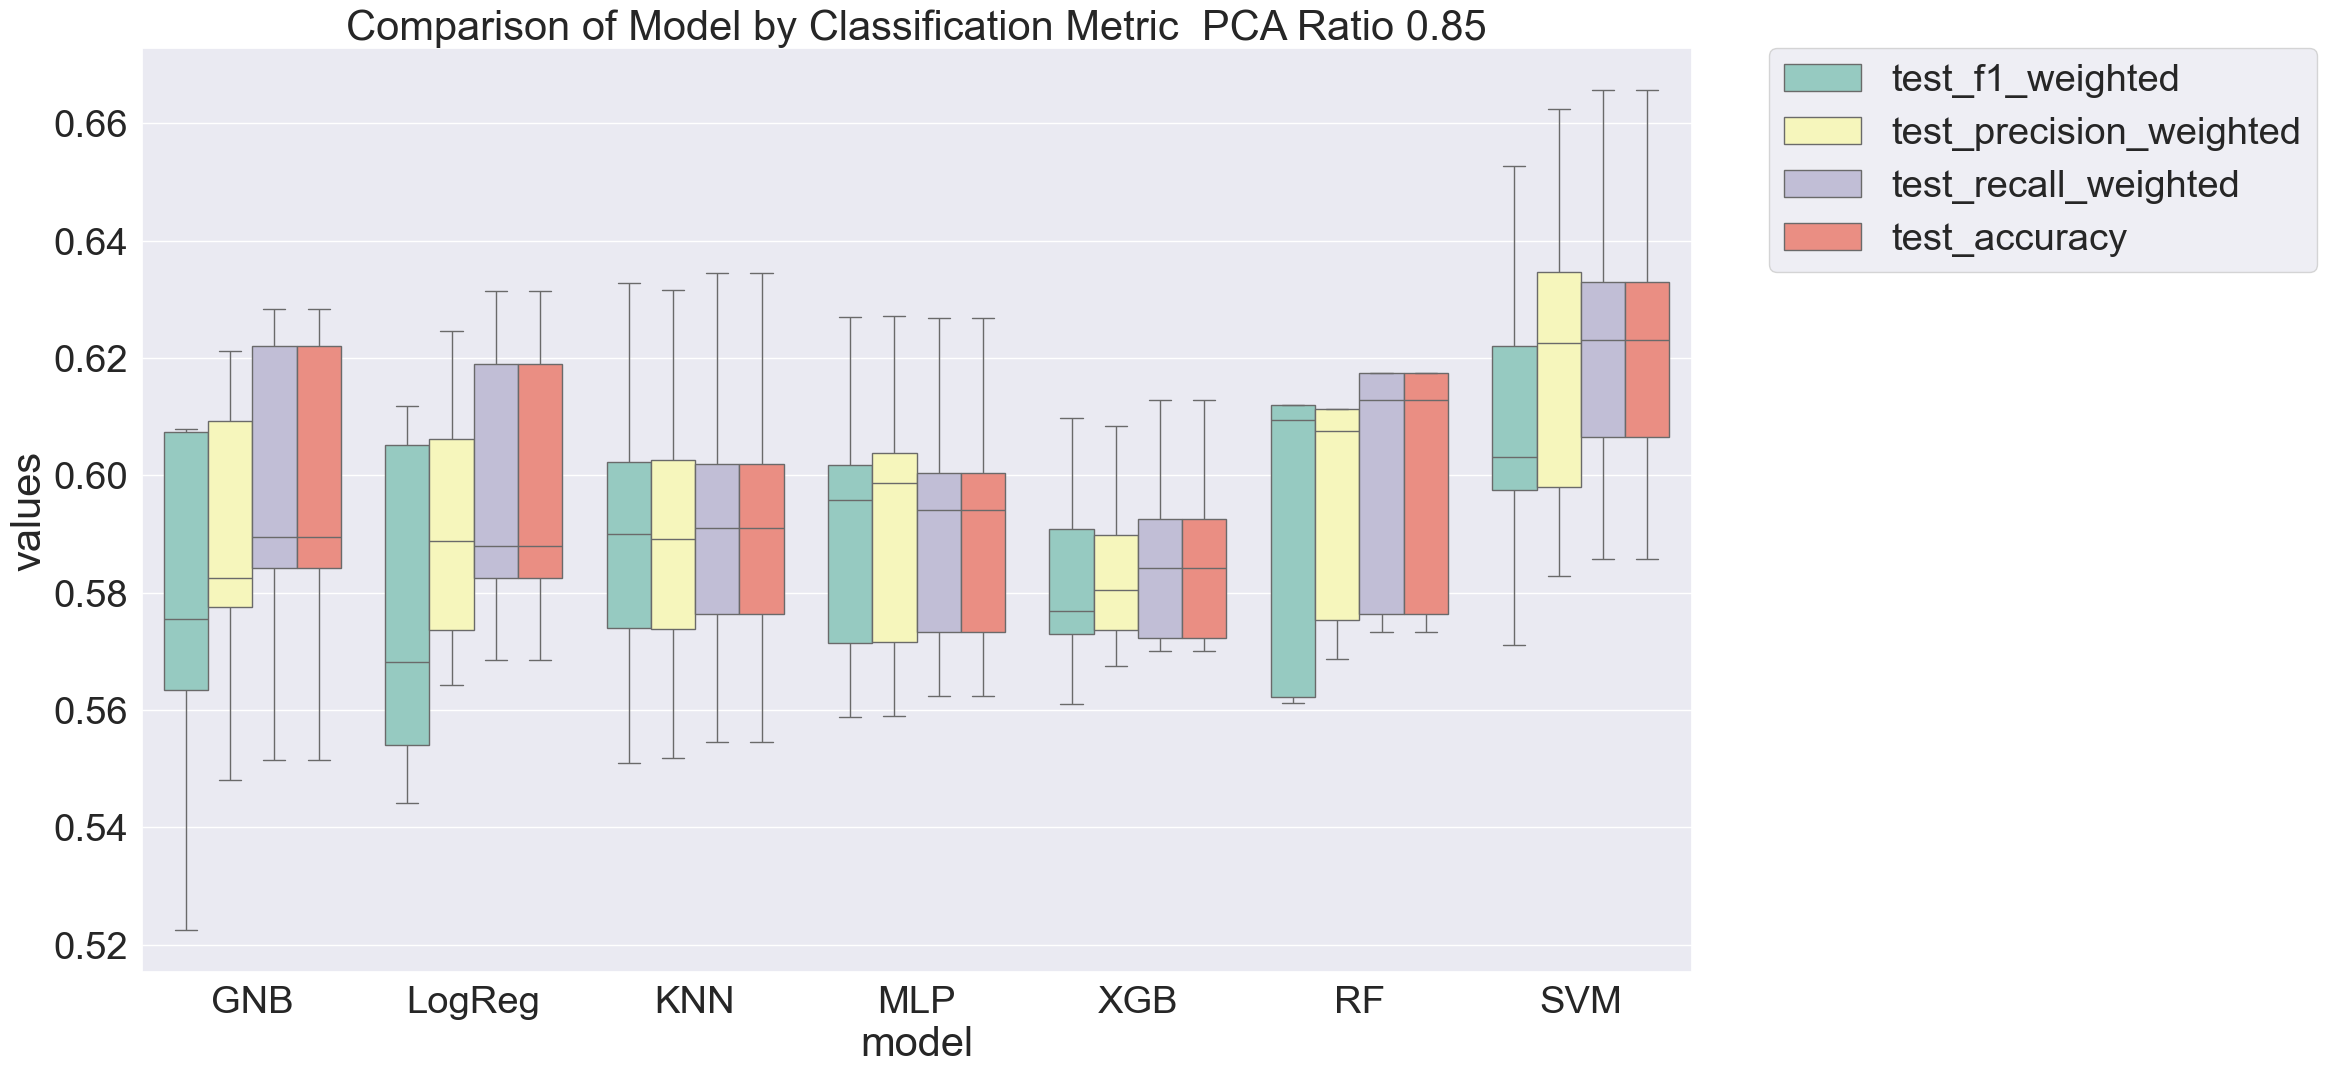

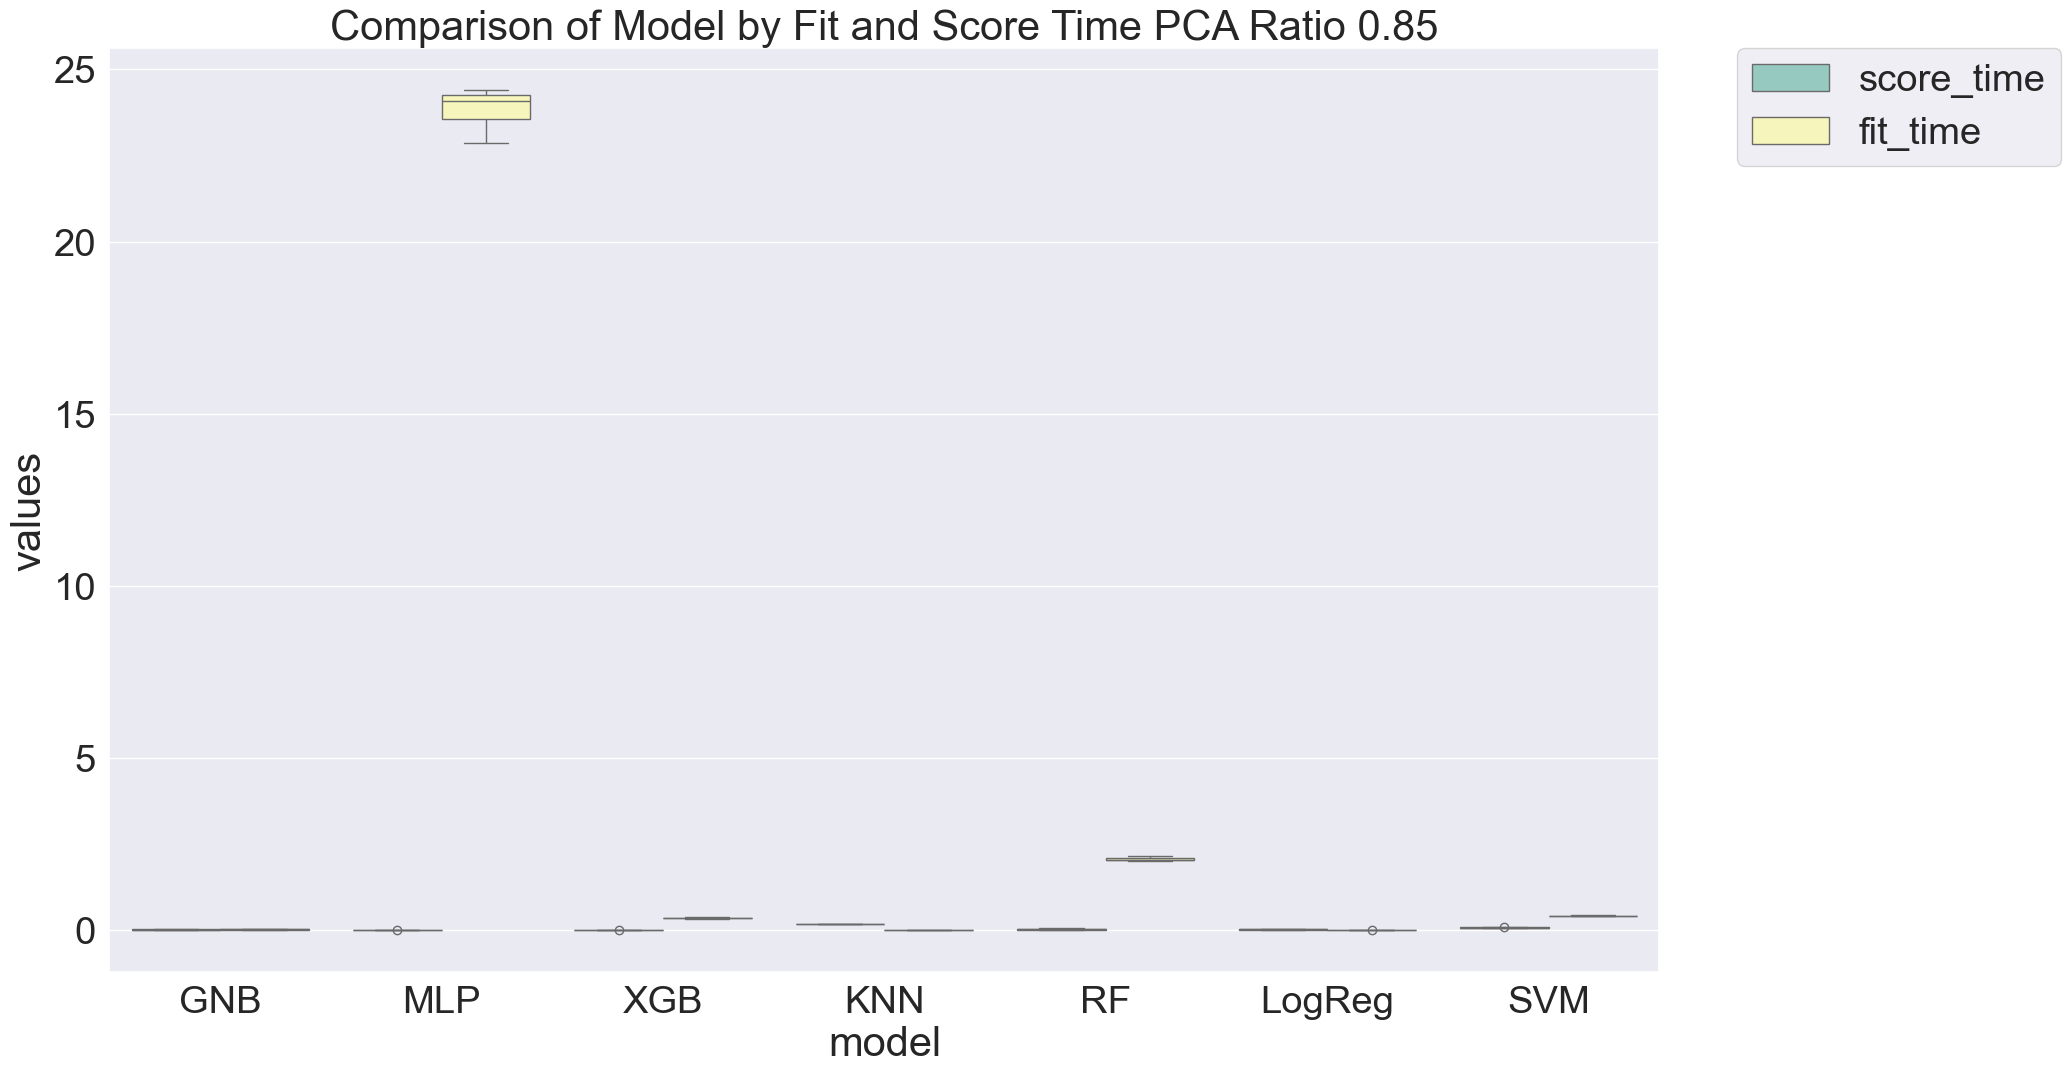

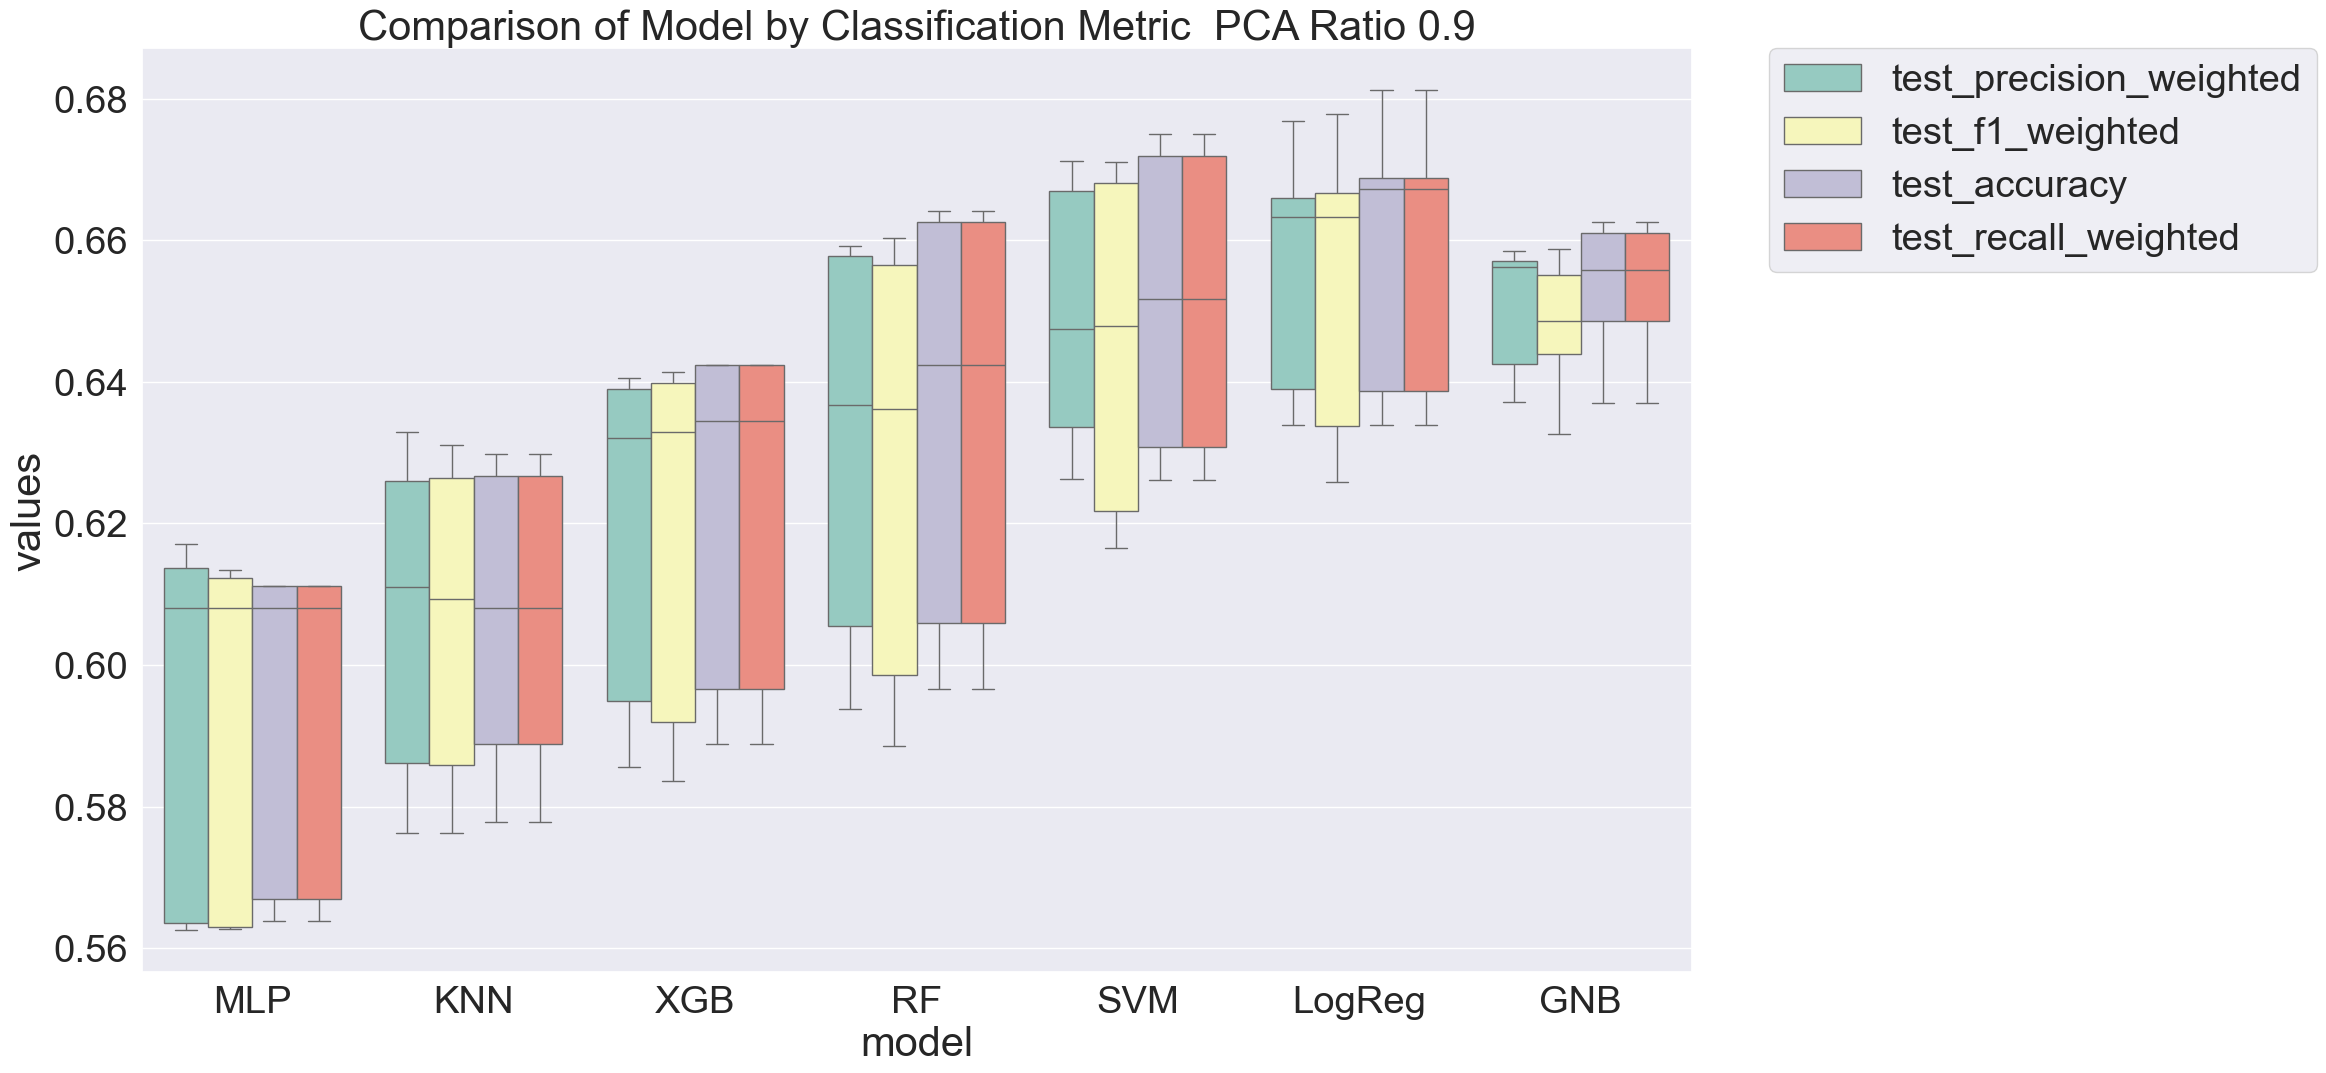

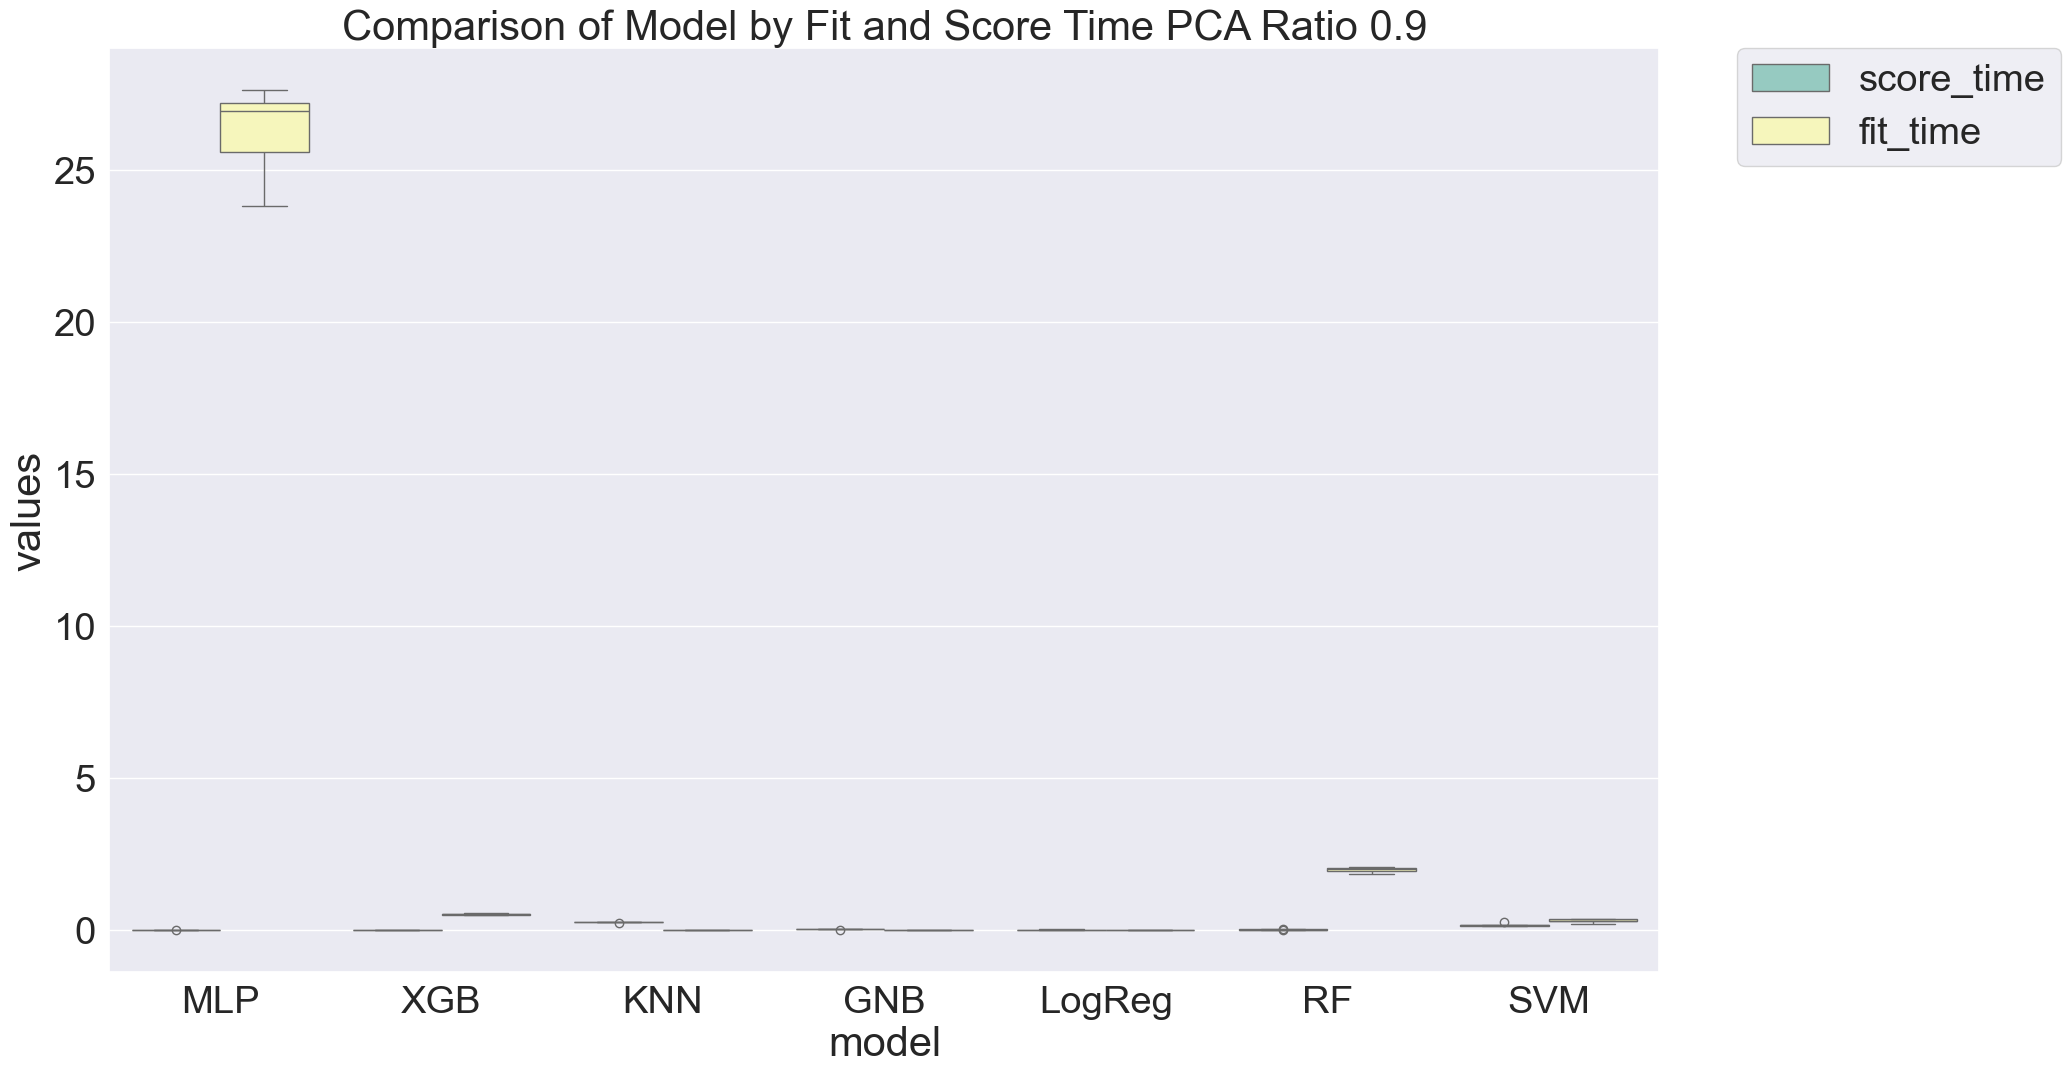

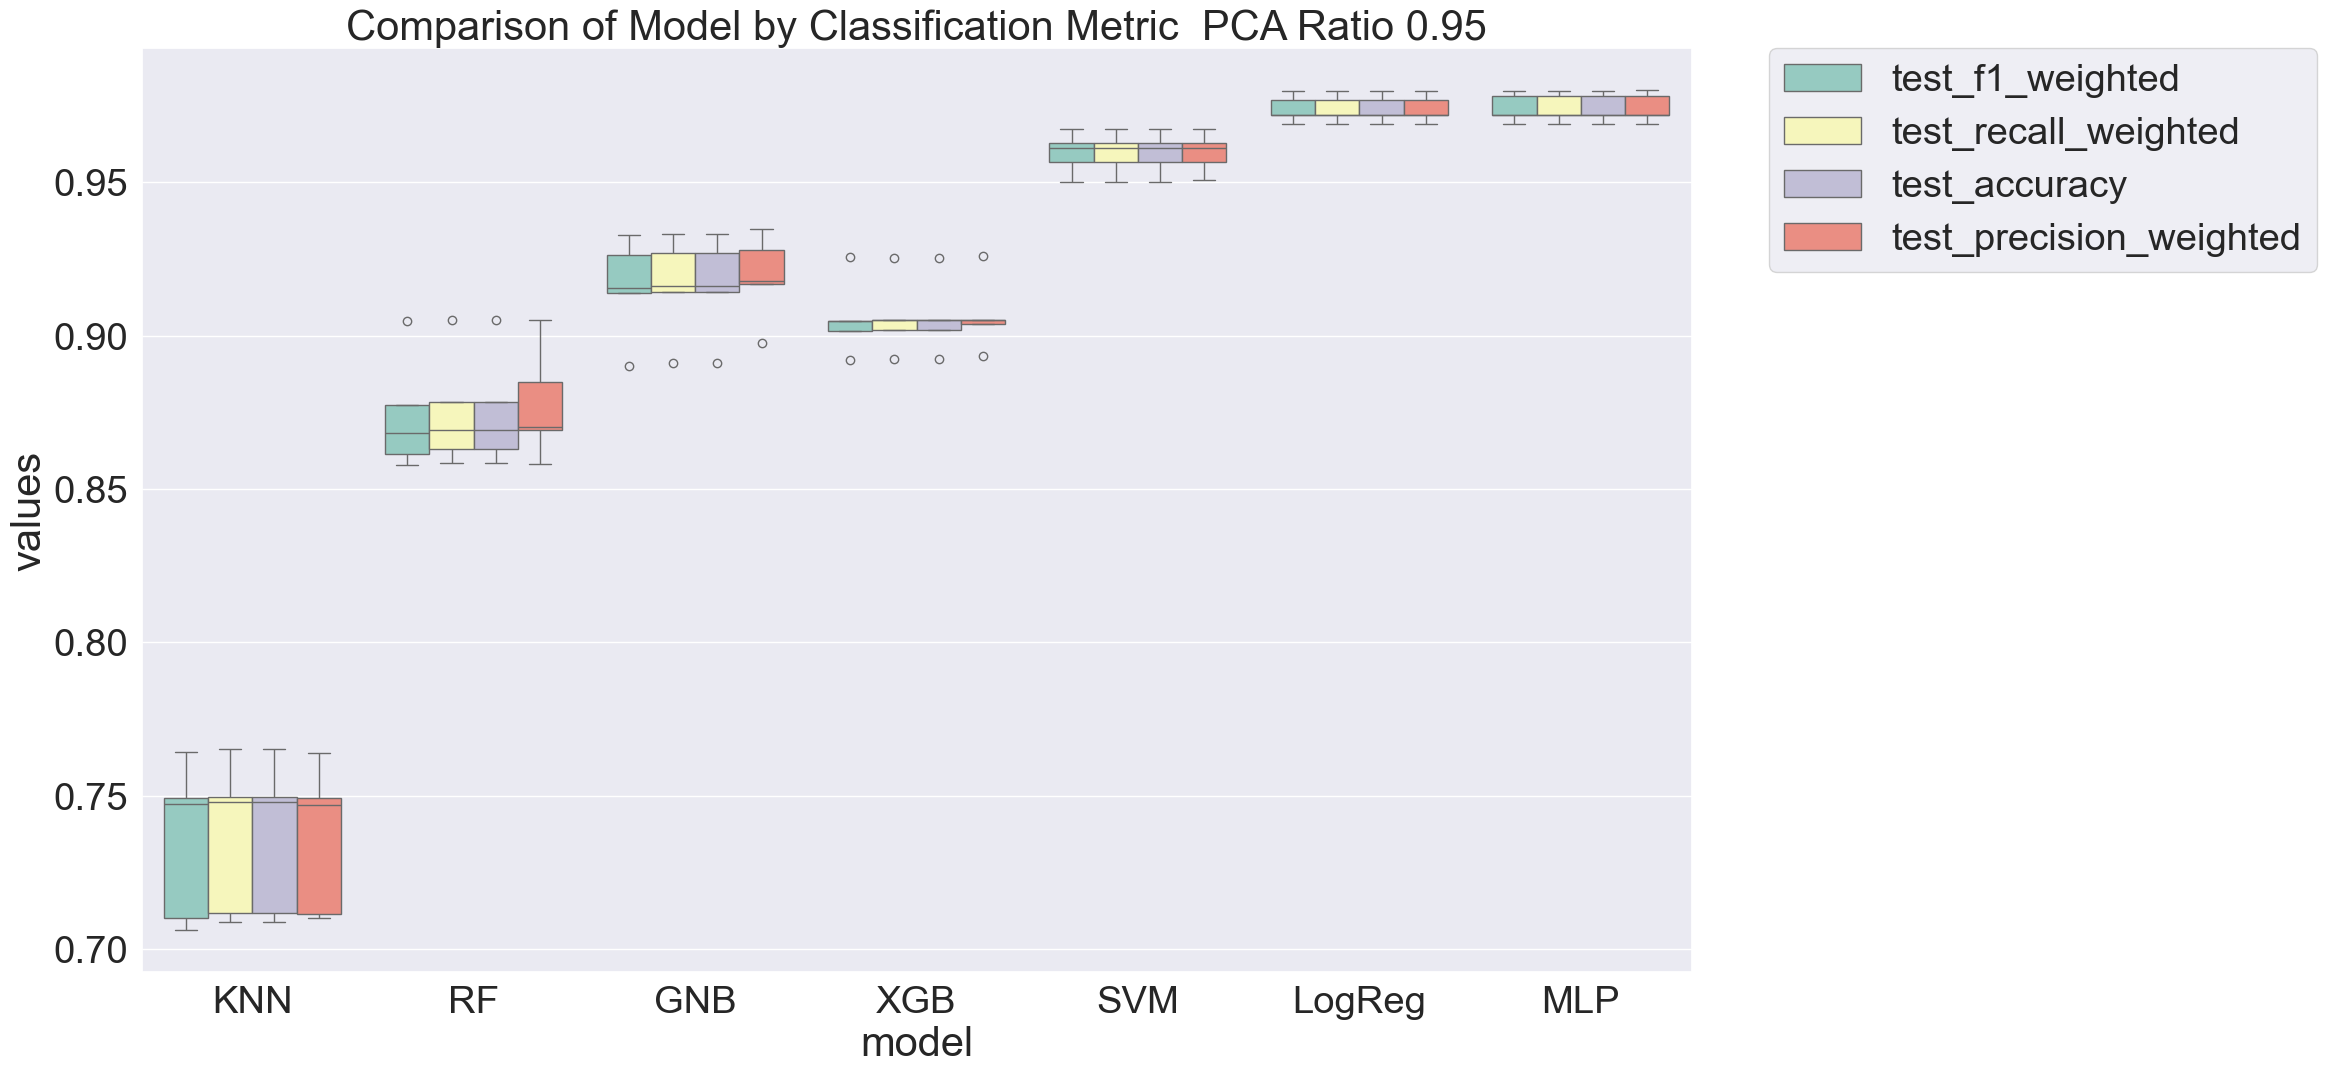

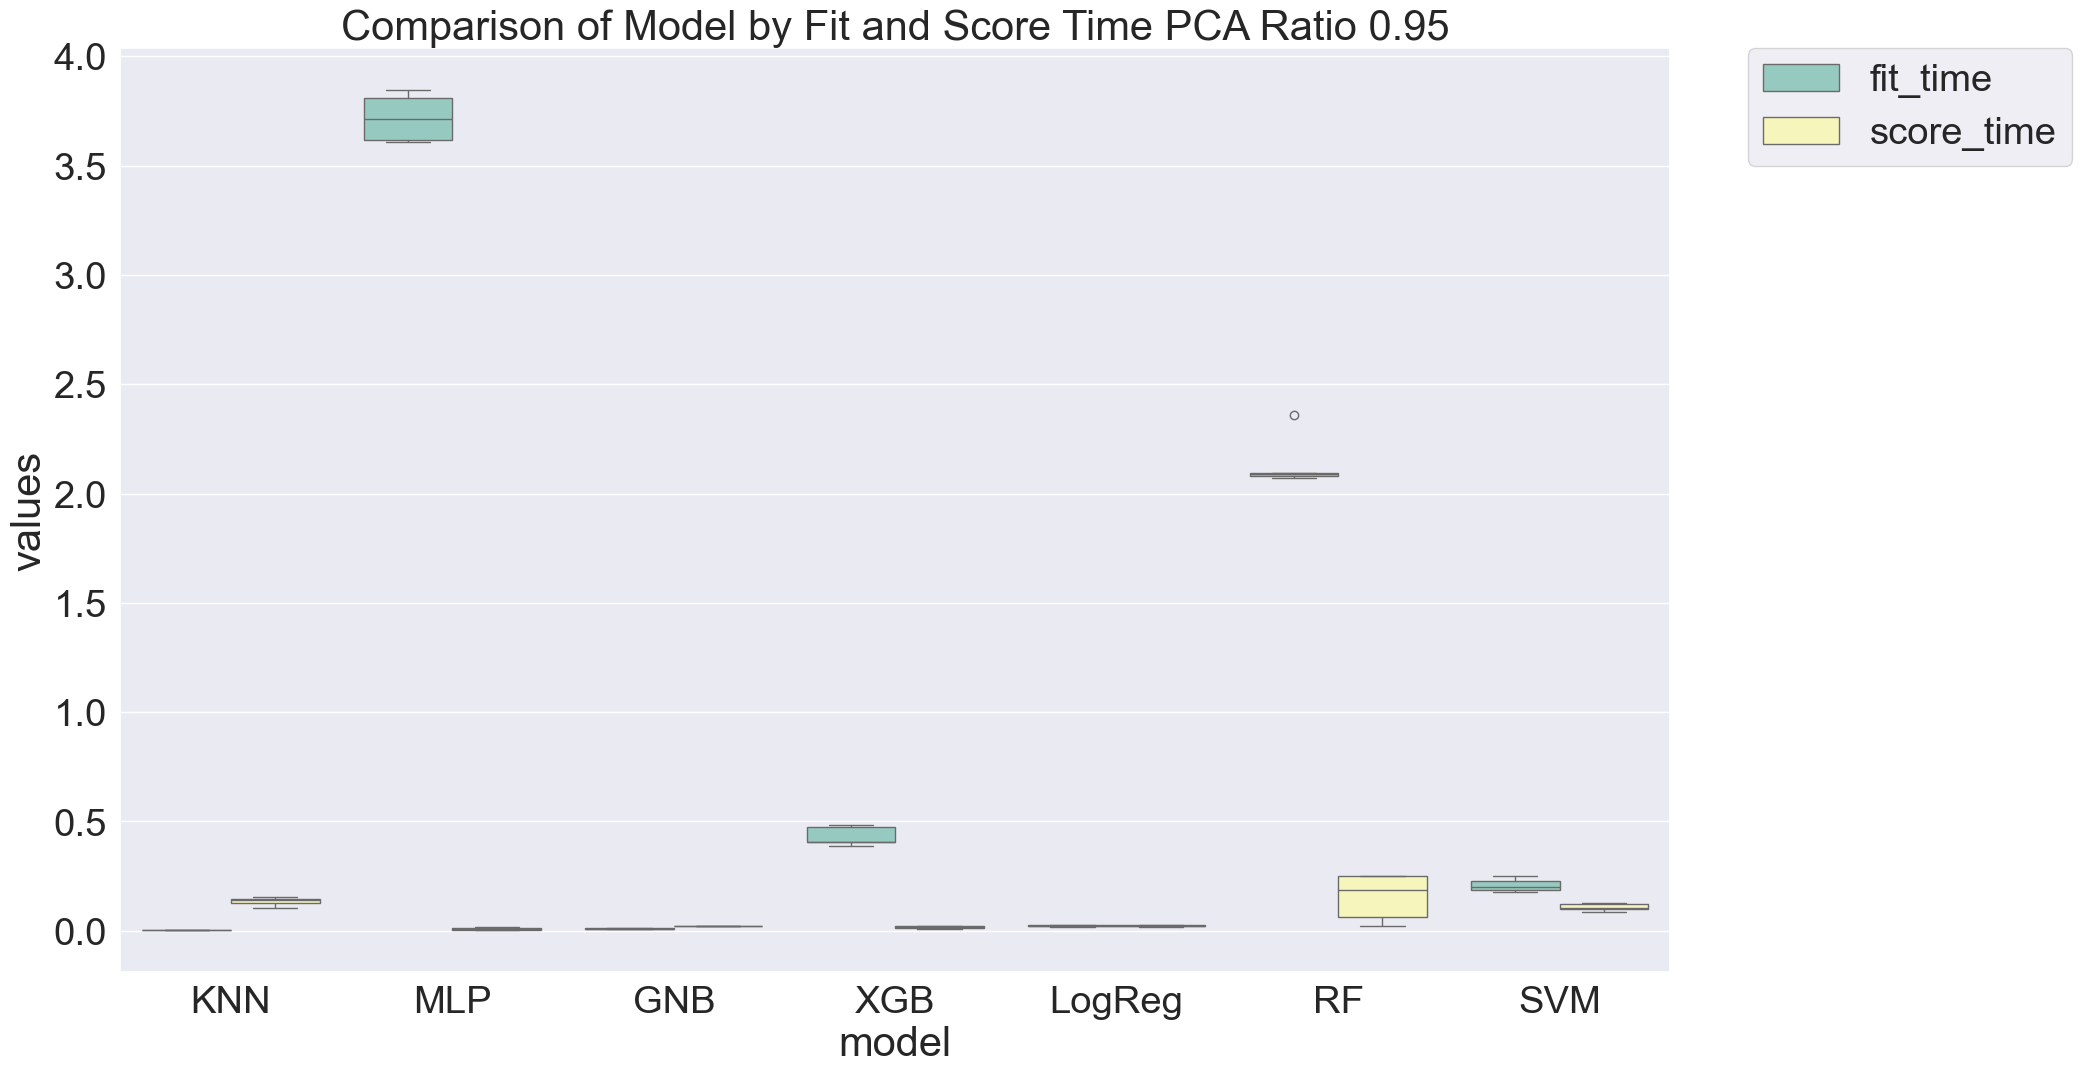

In [36]:
for i, (result, pca_ratio_used) in enumerate(results):  
    results_long_nofit, results_long_fit = evaluate_models(result)
    n_features = result.shape[1] - len(['model', 'fit_time', 'score_time'])  
    generate_plots(n_features, pca_ratio_used, results_long_nofit, results_long_fit)

In [ ]:
# from sklearn.metrics import mean_squared_error
# from sklearn.pipeline import make_pipeline

# # Initialize models for regression
# models = {
#     "Logistic Regression": LogisticRegression(),
#     "Random Forest": RandomForestClassifier(),
#     "K-Neighbors": KNeighborsClassifier(),
#     "Support Vector": SVC(),
#     "XGBoost": XGBClassifier(objective='reg:squarederror'),
#     "Gaussian Naive Bayes": GaussianNB(),
#     "Multilayer Perceptron": MLPClassifier(max_iter=1000)
# }

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print(f'X train shape: {X_train.shape}')
# print(f'X test shape: {X_test.shape}')

# results = {}

# for name, model in models.items():
#     pipeline = make_pipeline(StandardScaler(), model)
#     pipeline.fit(X_train, y_train)
#     y_pred = pipeline.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     results[name] = mse
#     print(f"{name} MSE: {mse:.4f}")

# # Displaying all results
# print("\nModel Mean Squared Errors:")
# for name, mse in results.items():
#     print(f"{name}: {mse:.4f}")